In [77]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [78]:
# define classes and data structures for code formatting
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [ ]:
# Define the state-space model for the battery
def battery_model_jacobian(state, current, params):

    SoC, V_CT, V_dif = state
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    return np.array([[-1., 0., 0.], [0., np.exp(-dt/tau_CT), 0.], [0., 0., np.exp(-dt/tau_dif)]])

def coulomb_counting(initial_SoC, Nsims, params):

    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params
    SoC_record = np.zeros((Nsims, 1))
    SoC_record[0] = initial_SoC
    for kk in range(1, Nsims):
        time = kk*dt
        current = current_user(time)
        SoC_record[kk] = SoC_record[kk-1] - (dt / Q_nom) * current
    
    return SoC_record

def battery_model(state, current, params):

    SoC, V_CT, V_dif = state
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    SoC_next = SoC - (dt / Q_nom) * current
    V_CT_next = np.exp(-dt / tau_CT) * V_CT + R_CT * (1 - np.exp(-dt / tau_CT)) * current
    V_dif_next = np.exp(-dt / tau_dif) * V_dif + R_dif * (1 - np.exp(-dt / tau_dif)) * current

    return np.array([SoC_next, V_CT_next, V_dif_next])

def V_OCV(SoC, dt, Nsims):

    data = pd.read_csv('VOCV_SOC_map.csv')
    SoC_arr = np.array(data['time'])
    V_arr = np.array(data[' V'])

    tfinal = Nsims*dt

    # create a unifrom time vector
    time_uniform = np.arange(0, tfinal, dt)

    # interpolate voltage
    v_interpolated = np.interp(time_uniform, SoC_arr, V_arr)

    closest_index = (np.abs(time_uniform - SoC)).argmin()

    return v_interpolated[closest_index]

def current_user2(time):
    
    if time%2>0 and time%2<0.2:
        return 25
    elif time%2>0.2 and time%2<1:
        return 18
    elif time%2>1 and time%2<1.8:
        return 8
    elif time%2>1.8 and time%2<2:
        return 0
    else:
        return 0

def current_user(t, params):

    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    time = t*dt
    if time%2>0 and time%2<0.2:
        return 25
    elif time%2>0.2 and time%2<1:
        return 18
    elif time%2>1 and time<1.8:
        return 8
    elif time%2>1.8 and time%2<2:
        return 0
    else:
        return 0

def battery_observation_model(state, current, params):

    SoC, V_CT, V_dif = state
    R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, Nsims = params

    VOCV = V_OCV(SoC, dt, Nsims)
    V = VOCV - V_CT - V_dif - R0*current

    return np.array([V])

def battery_observation_model_Jacobian(state, current, params):

    # for now assume that V_OCV(SoC) is a straight line joining
    ## (0, 3.2) and (1, 4.2)
    ## V_OCV = SoC + 3.2 - hence delVOCV/delSoC = 1

    return np.array([[1., -1., -1.]])
    #return np.array([[1.0, 0.0, 0.0]])

In [ ]:
# generate sigma points for UKF implementation
def sigma_points(X: Gaussian, alpha: float, kappa: float):
    n = X.mean.shape[0]
    lambda_ = alpha**2 * (n + kappa) - n

    try:
        L = np.linalg.cholesky((n + lambda_) * X.cov)
    except np.linalg.LinAlgError:
        # Add small regularization if cholesky decomposition fails
        L = np.linalg.cholesky((n + lambda_) * X.cov + 1e-8 * np.eye(n))

    sigma_pts = [X.mean]
    for i in range(n):
        sigma_pts.append(X.mean + L[i])
        sigma_pts.append(X.mean - L[i])

    return np.array(sigma_pts)

In [72]:
def gh_oned(num_pts=2):
    """Gauss-Hermite quadrature in 1D"""
    A = np.zeros((num_pts, num_pts))
    for ii in range(num_pts):
        row = ii + 1
        if ii == 0:
            A[ii, ii + 1] = np.sqrt(row)
            A[ii + 1, ii] = np.sqrt(row)
        elif ii == (num_pts - 1):
            A[ii - 1, ii] = np.sqrt(ii)
        else:
            A[ii, ii + 1] = np.sqrt(row)
            A[ii + 1, ii] = np.sqrt(row)

    pts, evec = np.linalg.eig(A)
    wts = evec[0, :] ** 2
    return pts, wts

def tensorize_nd(arrays):
    """Tensorize nodes or weights for n dimensions."""
    return np.array(list(product(*arrays)))

def gauss_hermite(dim, num_pts=2):
    """Gauss-Hermite quadrature for n dimensions.

    Parameters:
        dim (int): Number of dimensions.
        num_pts (int): Number of quadrature points per dimension.

    Returns:
        tuple: A tuple containing:
            - pts (ndarray): Tensorized quadrature points of shape (num_pts**dim, dim).
            - weights (ndarray): Quadrature weights of shape (num_pts**dim,).
    """
    # Generate 1D points and weights
    pts_1d, weights_1d = gh_oned(num_pts)

    # Create n-dimensional tensorized points and weights
    pts_arrays = [pts_1d] * dim
    weights_arrays = [weights_1d] * dim

    pts_nd = tensorize_nd(pts_arrays)  # Tensorized points
    weights_nd = tensorize_nd(weights_arrays)  # Tensorized weights

    # Combine weights for all dimensions
    weights_nd = np.prod(weights_nd, axis=1)

    return pts_nd, weights_nd

In [73]:
# gauss-hermite kalman filter main loop
def gauss_hermit_kalman_filter(data: Observations, X: Gaussian, xi: Gaussian, eta: Gaussian, m: int, params) -> KFTracker:

    num_steps = data.times.shape[0]
    d = X.mean.shape[0]
    dt = data.times[1] - data.times[0]

    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)

    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    Xnext = X
    on_obs = 0

    # sigma points are (9, 2)
    # weights are (9, )
    # singel sigma point is (2,)
    # single weight is (), just float

    for k in range(1, num_steps):

        sigma_pts, wghts = gauss_hermite(d, num_pts=m)

        L = np.linalg.cholesky(xi.cov)
        sigma_pts = Xnext.mean + np.sqrt(2)*sigma_pts @ L

        n = wghts.shape[0]

        # generate current
        current = current_user(k, params)

        # Propagate sigma points
        propagated_pts = np.array([battery_model(pt, current, params) for pt in sigma_pts]) # shape (9, 2)

        # Predict mean and covariance
        pred_mean = np.sum(wghts[:, np.newaxis] * propagated_pts, axis=0) # shape (2, )
        pred_cov = np.sum(wghts[:, np.newaxis, np.newaxis] *
                          [(pt - pred_mean).reshape(-1, 1) @ (pt - pred_mean).reshape(1, -1)
                           for pt in propagated_pts], axis=0) + xi.cov

        # Update step
        if on_obs < data.obs_ind.shape[0] and k == data.obs_ind[on_obs]:
            y = data.obs[on_obs]

            # Propagate sigma points through observation model
            obs_pts = np.array([battery_observation_model(pt, current, params) for pt in propagated_pts])

            # Predict measurement
            pred_y = np.sum(wghts[:, np.newaxis] * obs_pts, axis=0)

            S = np.sum(wghts[:, np.newaxis, np.newaxis] *
                       [(pt - pred_y).reshape(-1, 1) @ (pt - pred_y).reshape(1, -1)
                        for pt in obs_pts], axis=0) + eta.cov

            # Calculate cross-covariance
            cross_cov = np.sum(wghts[:, np.newaxis, np.newaxis] *
                               [(propagated_pts[i] - pred_mean).reshape(-1, 1) @
                                (obs_pts[i] - pred_y).reshape(1, -1)
                                for i in range(n)], axis=0)

            # Kalman gain
            K = cross_cov @ np.linalg.inv(S)

            # Update state estimate
            Xnext.mean = pred_mean + K @ (y - pred_y)
            Xnext.cov = pred_cov - K @ cross_cov.T #S @ K.T

            on_obs += 1
        else:
            Xnext.mean = pred_mean
            Xnext.cov = pred_cov

        mean_store[k] = Xnext.mean
        cov_store[k] = Xnext.cov
        std_store[k] = np.sqrt(np.diag(Xnext.cov))

    return KFTracker(mean_store, cov_store, std_store)

In [74]:
# generate true and observed data for simulations
def generate_data(times, N, dt, obs_freq, x0, R, n_states, params):
    g = 9.8
    xout = np.zeros((N, n_states))
    xout[0] = x0
    obs_ind = np.arange(obs_freq, N, obs_freq)
    num_obs = obs_ind.shape[0]
    yout = np.zeros(num_obs)

    for i in range(1, N):
        # generate current
        current = current_user(i, params)
        xout[i] = battery_model(xout[i-1], current, params)

    for i, idx in enumerate(obs_ind):
        currenti = current_user(i, params)
        yout[i] = battery_observation_model(xout[idx], currenti, params) + np.random.normal(0, np.sqrt(R))

    true_data = Observations(times, np.arange(N), xout, ['SoC', 'V_CT', 'V_dif'])
    obs_data = Observations(times, obs_ind, yout, ['V'])
    return true_data, obs_data

In [75]:
def plot_results(true_data, obs_data, kf_results, delta, R, ax):

    # Plot angle and angular rate

    ax.plot(true_data.times, true_data.obs[:, 0], 'g-', label='SoC', linewidth=2)
    ax.plot(obs_data.times[obs_data.obs_ind], obs_data.obs, 'go', label='Observations: V')
    ax.plot(true_data.times, kf_results.means[:, 0], 'g--', label='Estimated SoC')
    ax.fill_between(true_data.times,
                    kf_results.means[:, 0] - 2*kf_results.stds[:, 0],
                    kf_results.means[:, 0] + 2*kf_results.stds[:, 0],
                    color='g', alpha=0.2, label=r'SOC 2$\pm \sigma$')

    ax.plot(true_data.times, true_data.obs[:, 1], 'b-', label='V_CT', linewidth=2)
    ax.plot(true_data.times, kf_results.means[:, 1], 'b--', label='Estimated V_CT')
    ax.fill_between(true_data.times,
                    kf_results.means[:, 1] - 2*kf_results.stds[:, 1],
                    kf_results.means[:, 1] + 2*kf_results.stds[:, 1],
                    color='b', alpha=0.2, label=r'V_CT 2$\pm \sigma$')

    RMSE = np.sqrt(np.mean((kf_results.means - true_data.obs)**2))
    ax.set_title(f"Δ={delta}, R={R}, RMSE = {np.round(RMSE, 4)}")
    ax.set_xlabel("Time")
    ax.set_ylabel("State Estimate")
    ax.legend(fontsize=8, loc='upper right')

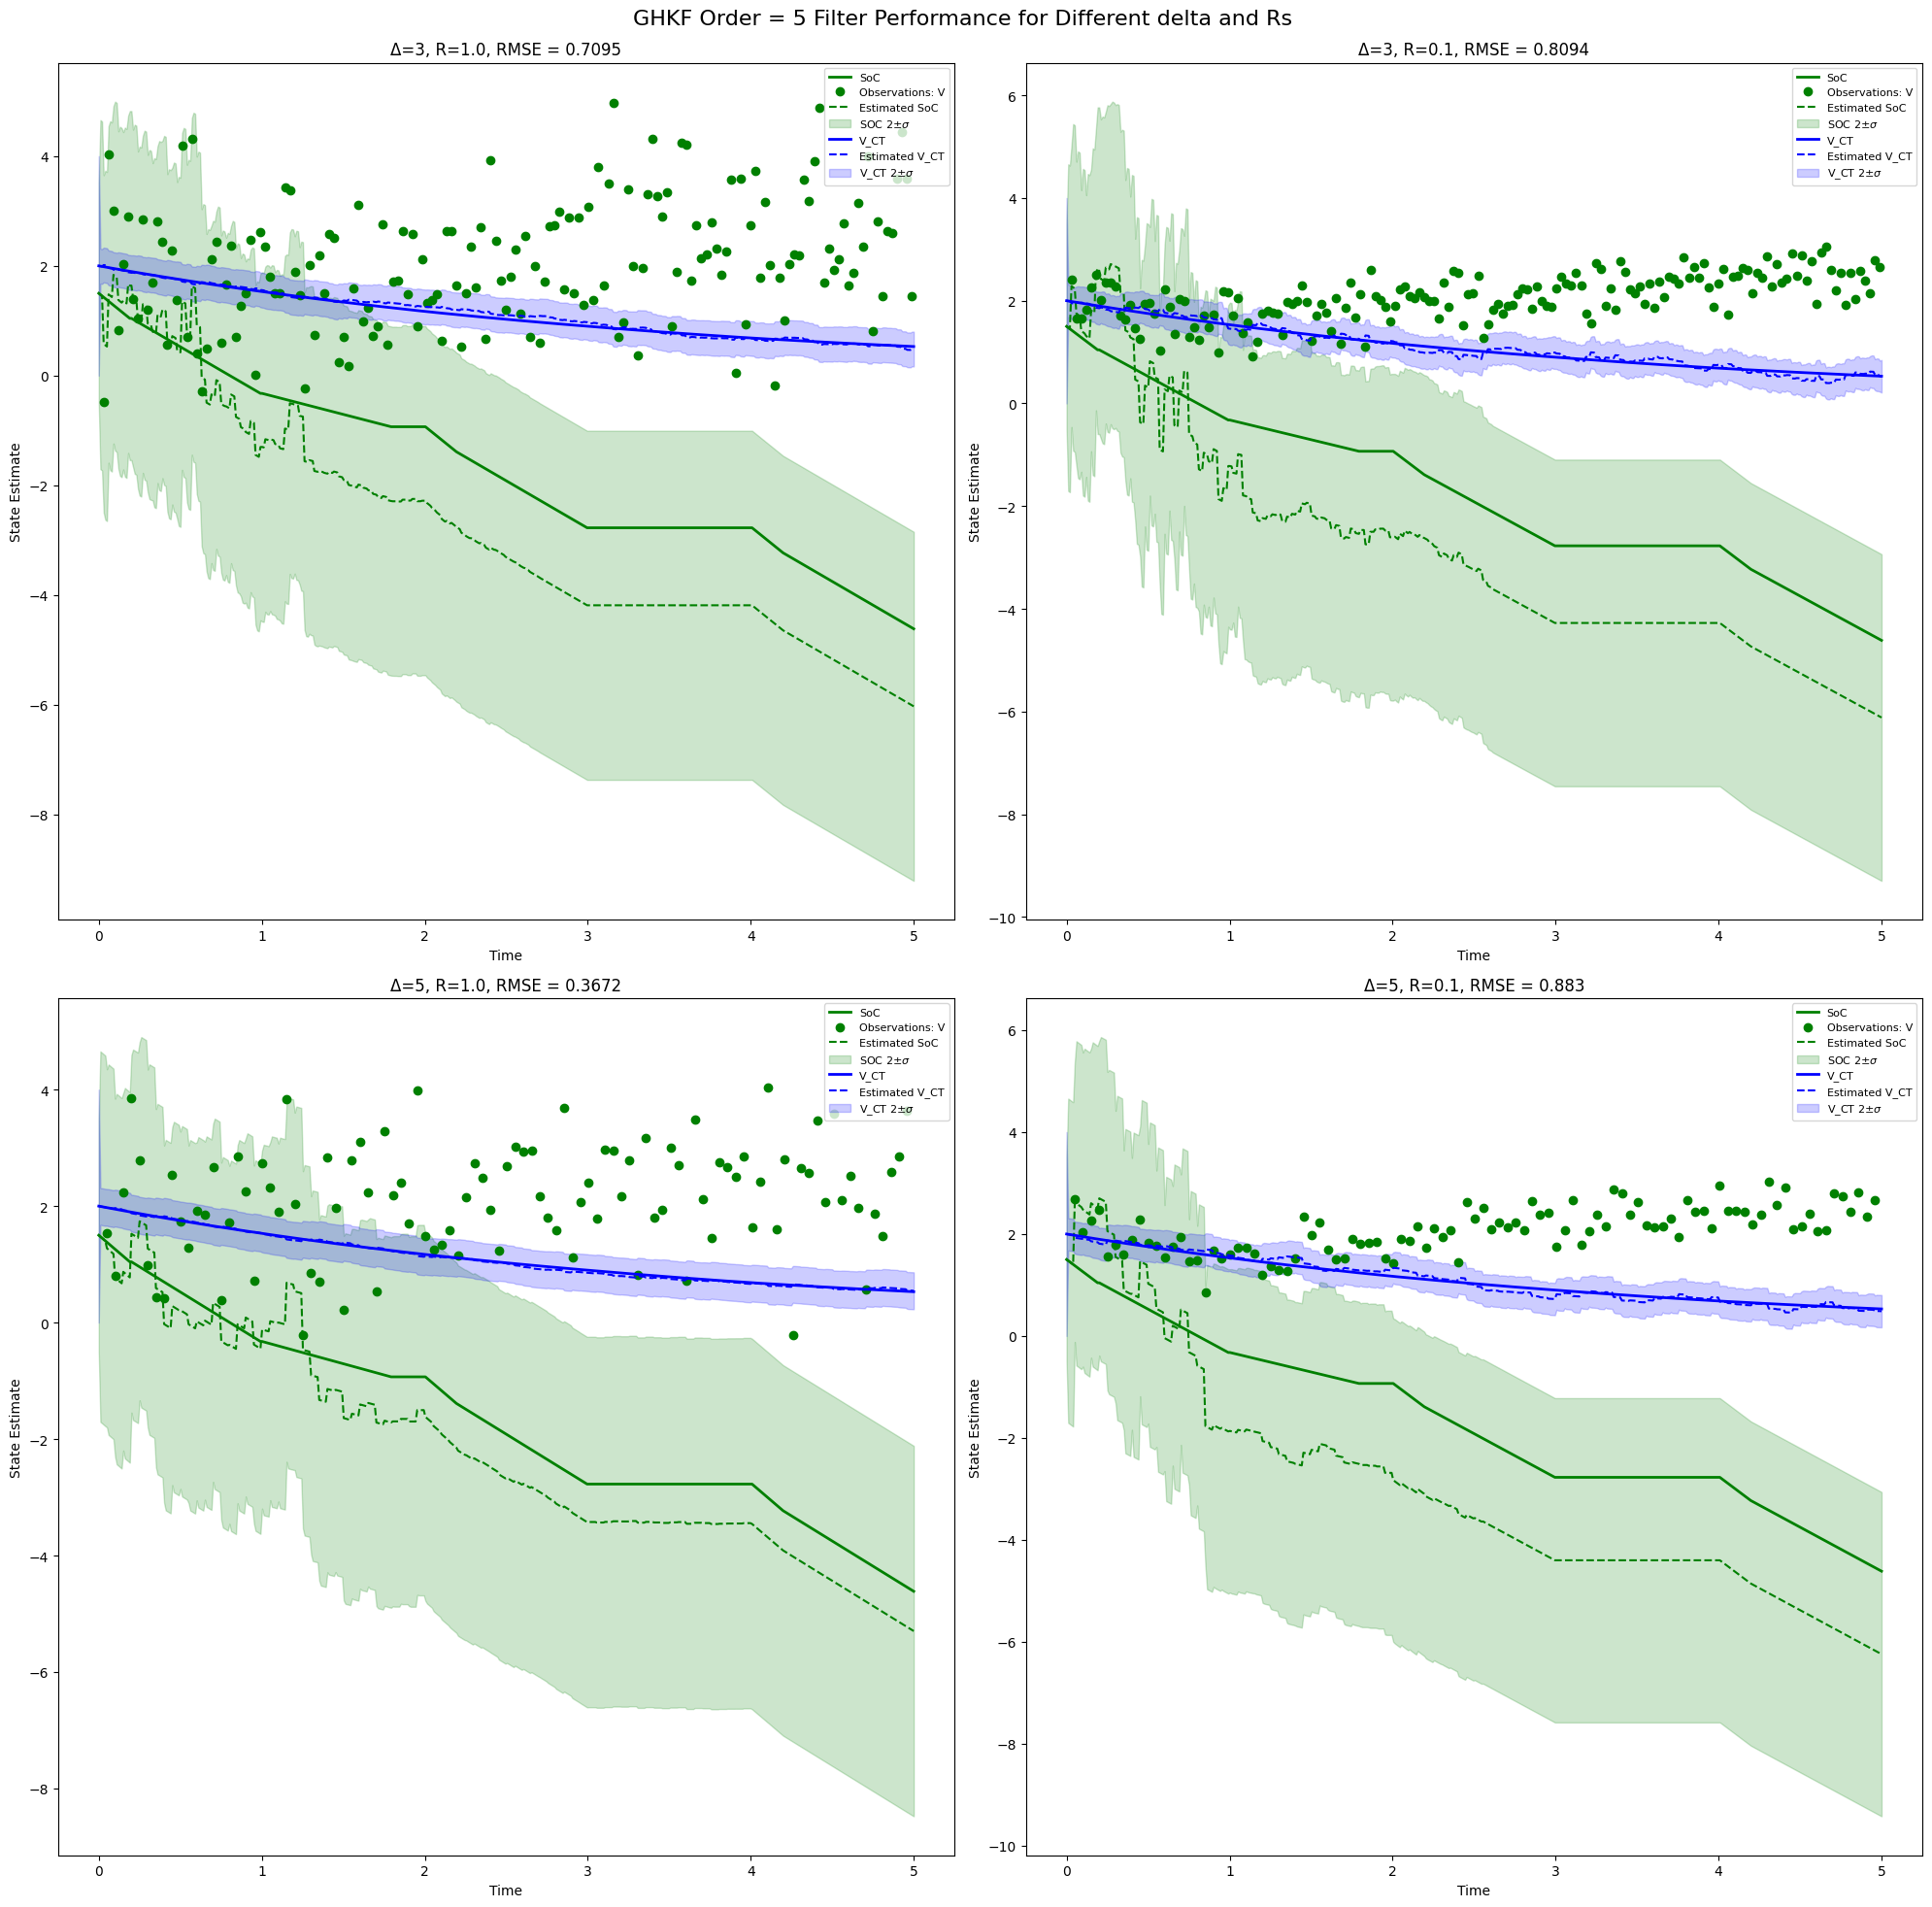

In [76]:
# Parameters
dt = 0.01
N = 500
n_states = 3
Tf = N * dt
x0 = np.array([1.50, 2, 0])
covval = 8.432 * 10**-4

# battery model parameters
R_CT, tau_CT, R_dif, tau_dif, Q_nom, R0 = 1.6*10**-3, 3.68, 7.7*10**-3, 84.34, 10.4, 6*10**-3
params_ghkf = [R_CT, tau_CT, R_dif, tau_dif, dt, Q_nom, R0, N]

# UKF parameters
alpha = 1e-3
beta = 2.0
kappa = 0.2

# Values of delta and R
#R_values = np.array([1, 0.1, 0.01, 0.001])
#delta_values = np.array([5, 10, 20, 40])

# for overlays
R_values = np.array([1, 0.1])
delta_values = np.array([3, 5])

# Initialize plot
fig, axes = plt.subplots(len(delta_values), len(R_values), figsize=(20, 20))
fig.suptitle("GHKF Order = 5 Filter Performance for Different delta and Rs \n", fontsize=16)
axes = axes.ravel()

# Iterate over delta and R
idx = 0
kf_results_store = []
for delta in delta_values:
    for R in R_values:
        # Generate true and noisy data
        times = np.linspace(0, Tf, N)
        true_data, obs_data = generate_data(times, N, dt, delta, x0, R, n_states, params_ghkf)

        # Set up UKF
        Q = np.array([[1000*covval, 0.0, 0.0], 
                  [0.0, 10*covval, 0.0], 
                  [0.0, 0.0, 1*covval]])
        X = Gaussian(x0, np.eye(n_states))
        xi = Gaussian(np.zeros(n_states), Q)
        eta = Gaussian(0, R)
        order = 5

        # Run UKF
        kf_results = gauss_hermit_kalman_filter(obs_data, X, xi, eta, order, params_ghkf)
        kf_results_store.append(kf_results)

        # Plot results in the corresponding subplot
        plot_results(true_data, obs_data, kf_results, delta, R, axes[idx])
        idx += 1

# Adjust layout
plt.tight_layout()
plt.show()